In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

- The Data Contains over half a million rows and 8 columns 

In [52]:
retail = pd.read_csv('Datasets/online_retail_II.csv')
print(retail.shape)
retail.head()

(525461, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01/12/2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01/12/2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01/12/2009 07:45,1.25,13085.0,United Kingdom


- There are null values in `Description, Customer ID` Columns
- InvoiceDate needs to be datetime Data type.
- Customer ID needs to be an Integer Data type.

In [53]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB


In [54]:
retail["InvoiceDate"] = pd.to_datetime(retail["InvoiceDate"], format='%d/%m/%Y %H:%M')

retail["Customer ID"] = retail["Customer ID"].astype("Int64")

- Both `Quantity | Price` are Skewed.
- There can't be negative quantities and prices so I need to handle those values.

In [55]:
retail[["Quantity", "Price"]].skew()

Quantity     36.044617
Price      -140.768446
dtype: float64

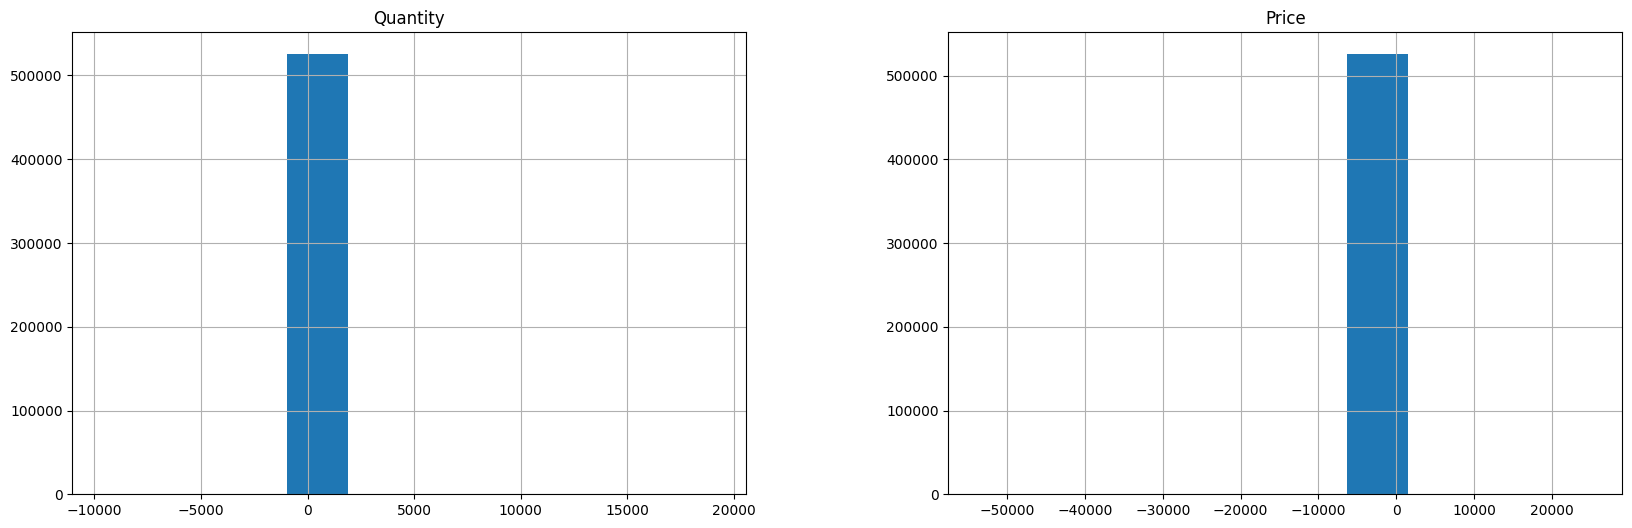

In [56]:
retail[["Quantity", "Price"]].hist(figsize=(20, 6));
plt.savefig('figs/histogram of the price and quantity.png', format='png')

In [57]:
mask1 = (retail["Price"] > 0)
mask2 = (retail["Quantity"] > 0)
retail = retail[mask1 & mask2]

- Due to the huge number of missing Customer IDs I will not drop them but i'll keep them in a new dataframe.
- Because there are only 0.6 % of the data that contains NaN values in both `Customer ID, Description` i will drop those values.

In [58]:
(retail.isnull().sum().sort_values(ascending=False) / retail.shape[0]).round(3)

Customer ID    0.203
Invoice        0.000
StockCode      0.000
Description    0.000
Quantity       0.000
InvoiceDate    0.000
Price          0.000
Country        0.000
dtype: float64

In [59]:
retail_null = retail[retail.isnull().any(axis=1)]
retail_null.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,<NA>,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,<NA>,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,<NA>,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,<NA>,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,<NA>,United Kingdom


- Now let's put the new Not containing null retail dataset into a df variable. for further cleaning.

In [60]:
df = retail.dropna()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [61]:
df[['Price', 'Quantity']].describe()

,Price,Quantity
count,407664.000000,407664.000000
mean,3.294438,13.585585
std,34.757965,96.840747
min,0.001000,1.000000
25%,1.250000,2.000000
50%,1.950000,5.000000
75%,3.750000,12.000000
max,10953.500000,19152.000000


- As per the Data Source The Invoice that starts with `C` means that this invoice has been canceled. so I will keep those canceled invoices into a new variable. The new Retail data doesn't contain any canceled invoices.

In [62]:
(df[df['Invoice'].str.contains("C")]).shape

(0, 8)

- There are some Outliers in the `Price, Quantity` columns

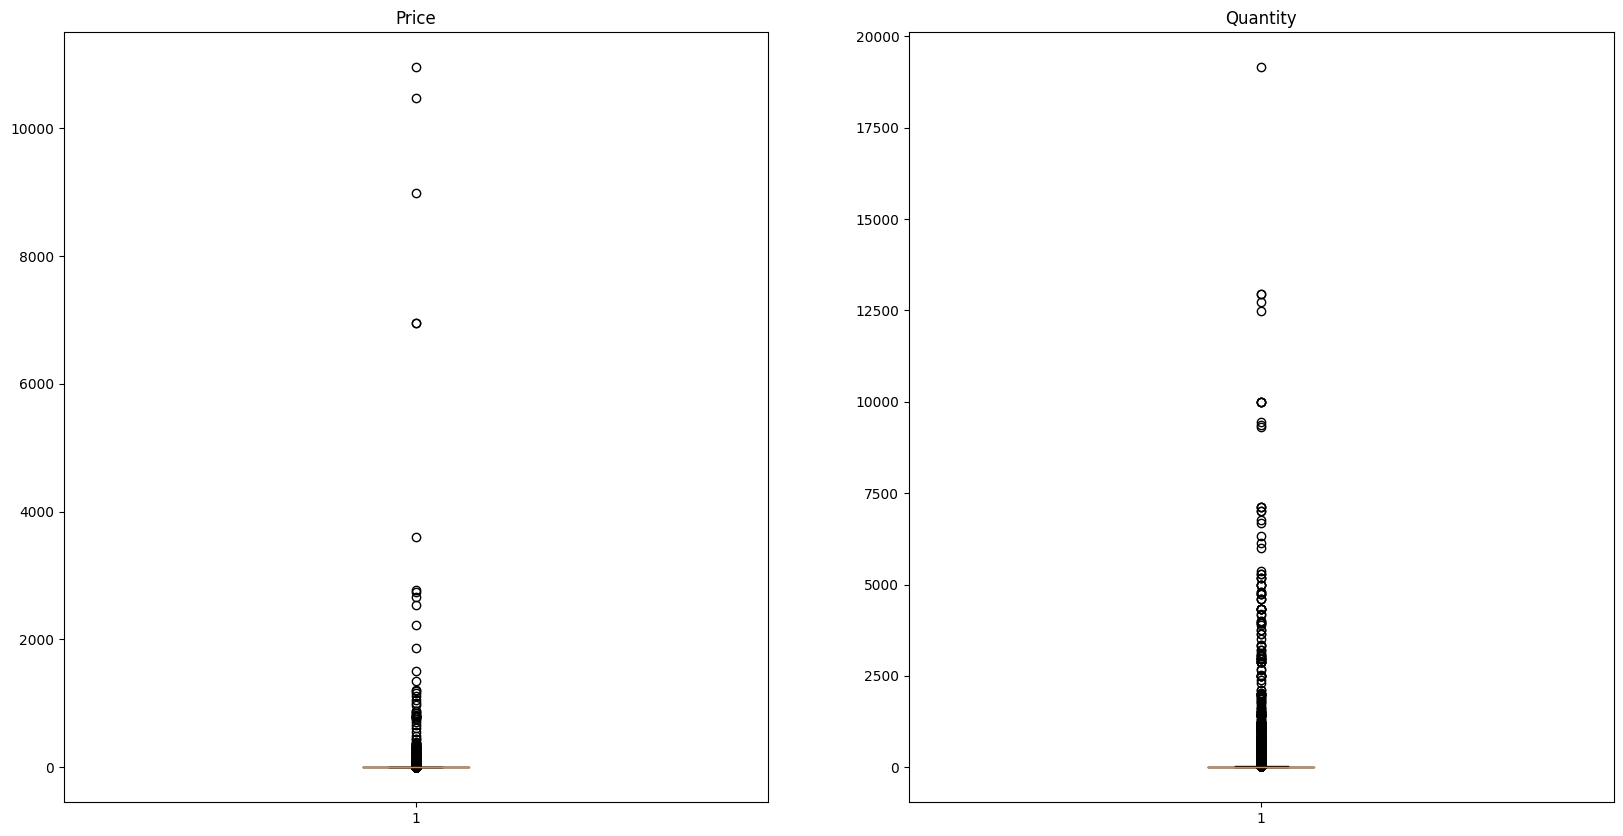

In [63]:
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Flatten the axs array to easily access each subplot
axs = axs.flatten()

# Create a boxplot for each column in the DataFrame
for i, column in enumerate(df[['Price', 'Quantity']].columns):
    axs[i].boxplot(df[column])
    axs[i].set_title(column)
    

plt.savefig('figs/box-plot for price and quantity columns.png', format='png')
plt.show()

- I will use the IQR (Inter Quartile Range) method to detect those outliers. I will also build a function for it.

In [64]:
def IQR(column):
    q3, q1 = np.percentile(df[column], [90, 10])
    IQR = q3 - q1
    print(f"Q3: {q3} \t Q1: {q1} \t IQR: {IQR}")

    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR  

    mask1 = df[column] > upper_bound
    mask2 = df[column] < lower_bound

    outliers = df[(mask1) | (mask2)]

    return outliers

In [65]:
outliers = IQR("Quantity")
print(f"The Numboer of rows that represent Outliers are {len(outliers)}")
df.drop(outliers.index, inplace=True)

Q3: 24.0 	 Q1: 1.0 	 IQR: 23.0
The Numboer of rows that represent Outliers are 11689


In [66]:
outliers = IQR("Price")
print(f"The Numboer of rows that represent Outliers are {len(outliers)}")
df.drop(outliers.index, inplace=True)

Q3: 6.75 	 Q1: 0.65 	 IQR: 6.1
The Numboer of rows that represent Outliers are 3293


In [67]:
df[df.duplicated()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329,United Kingdom
383,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329,United Kingdom
384,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329,United Kingdom
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329,United Kingdom
...,...,...,...,...,...,...,...,...
523258,538035,20728,LUNCH BAG CARS BLUE,3,2010-12-09 13:03:00,1.65,16065,United Kingdom
523356,538051,22659,LUNCH BOX I LOVE LONDON,2,2010-12-09 13:24:00,1.95,18041,United Kingdom
525170,538155,21907,I'M ON HOLIDAY METAL SIGN,1,2010-12-09 16:52:00,2.10,16907,United Kingdom
525293,538166,21915,RED HARMONICA IN BOX,5,2010-12-09 18:09:00,1.25,17965,United Kingdom


#### Feature Engineering:
    - Creating UnitePrice column
    - Creating Year column
    - Creating Month column
    - Creating Day column
    - Creating Hour column

In [68]:
df["UnitPrice"] = (df["Quantity"] / df["Price"]).round(2)
df["UnitPrice"].head()

0     1.73
1     1.78
2     1.78
3    22.86
4    19.20
Name: UnitPrice, dtype: float64

In [69]:
# Extract year, month, and day into separate columns
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour

df[['Year', 'Month', 'Day', 'Hour']].sample(5)

,Year,Month,Day,Hour
110729,2010,3,3,16
413520,2010,10,25,14
320010,2010,8,26,19
493195,2010,11,26,14
363828,2010,9,30,10


### Now the Data is Clean let's have a look at we achieved so far. :)
- Let's Save Our Beautiful New DataSet.

In [70]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,UnitPrice,Year,Month,Day,Hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,1.73,2009,12,1,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,1.78,2009,12,1,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,1.78,2009,12,1,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,22.86,2009,12,1,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,19.20,2009,12,1,7


In [71]:
df.to_csv("New Retail.csv")

# **Now It's Time for The Data Analysis:**
### I will lead with some simple questions to help us dig deep into the dataset.
1. Which customers placed the most orders?
2. Which customers spent the most money?
3. Which months were the most for this online retail store?
4. Which days were the most and least popular for this online retail store?
5. Which hours of the day were most and least popular for this online retail store?
6. Which items were ordered the most and least?
7. Which countries placed the most and fewest orders?
8. Which countries spent the most and least money?

- **Which customers placed the most orders?** 

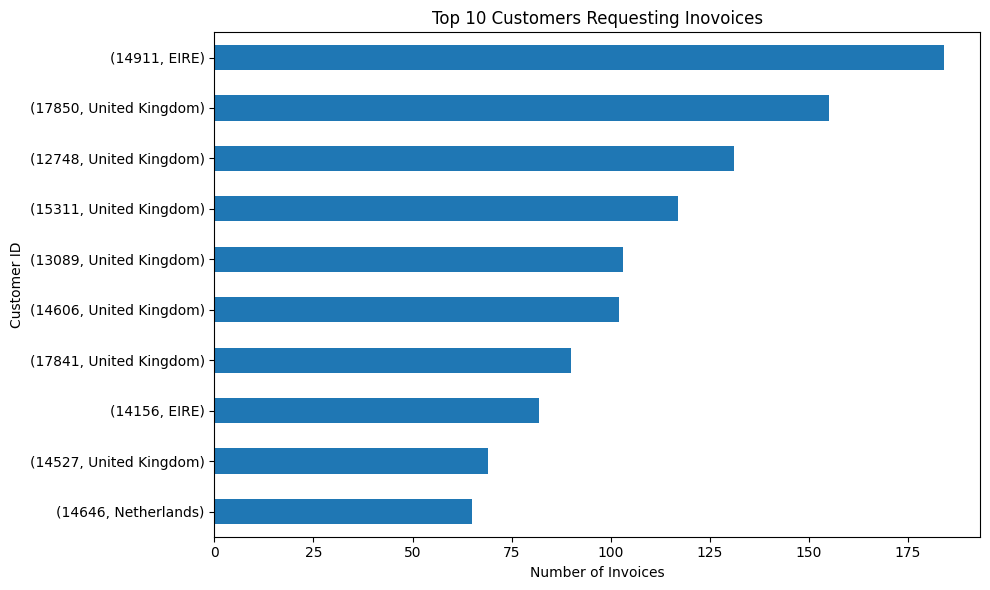

In [72]:
data_plot = df.groupby(["Customer ID", "Country"])["Invoice"].nunique()

# Sort the data in descending order and select the top 10 customers
top_10_customers = data_plot.sort_values(ascending=False).head(10)

# Plotting the top 10 customers
fig, ax = plt.subplots(figsize=(10, 6))
top_10_customers.plot(kind="barh", ax=ax)

ax.set_xlabel("Number of Invoices")
ax.set_ylabel("Customer ID")
ax.set_title("Top 10 Customers Requesting Inovoices")

# Invert the y-axis to show the highest count at the top
ax.invert_yaxis()

plt.tight_layout()

plt.savefig("figs/Which customers placed the most orders.png", format="png")
plt.show()

- ***Which customers spent the most money?***

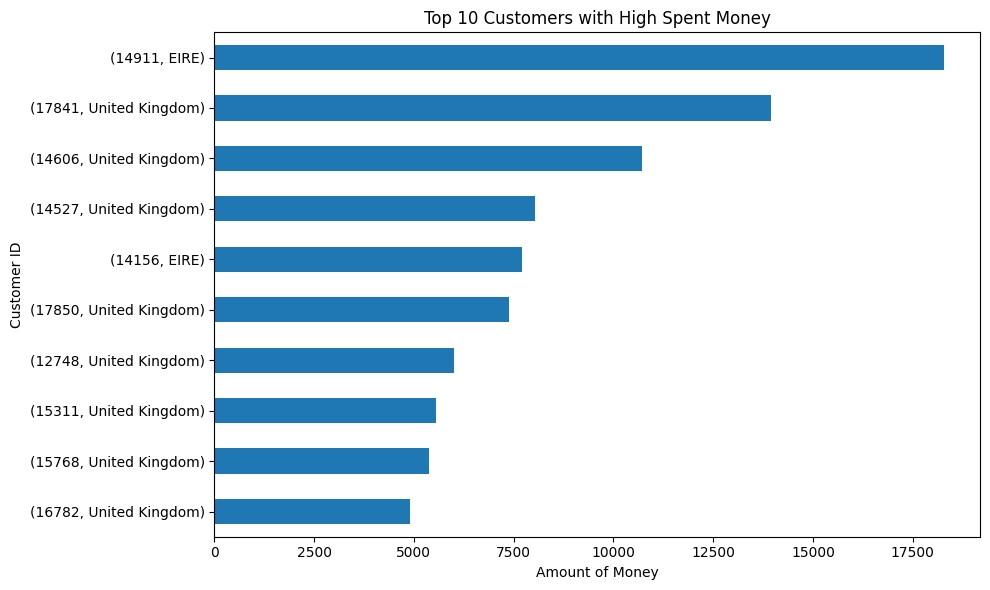

In [73]:
data_plot = df.groupby(["Customer ID", "Country"])["Price"].sum()

# Sort the data in descending order and select the top 10 customers
top_10_customers = data_plot.sort_values(ascending=False).head(10)

# Plotting the top 10 customers
fig, ax = plt.subplots(figsize=(10, 6))
top_10_customers.plot(kind="barh", ax=ax)

ax.set_xlabel("Amount of Money")
ax.set_ylabel("Customer ID")
ax.set_title("Top 10 Customers with High Spent Money")

# Invert the y-axis to show the highest count at the top
ax.invert_yaxis()

plt.tight_layout()

plt.savefig("figs/Which customers spent the most money.png", format="png")
plt.show()

- ***Which months were the most popular for this online retail store?***
    - Oct_10, Nov_10 are the top two months.

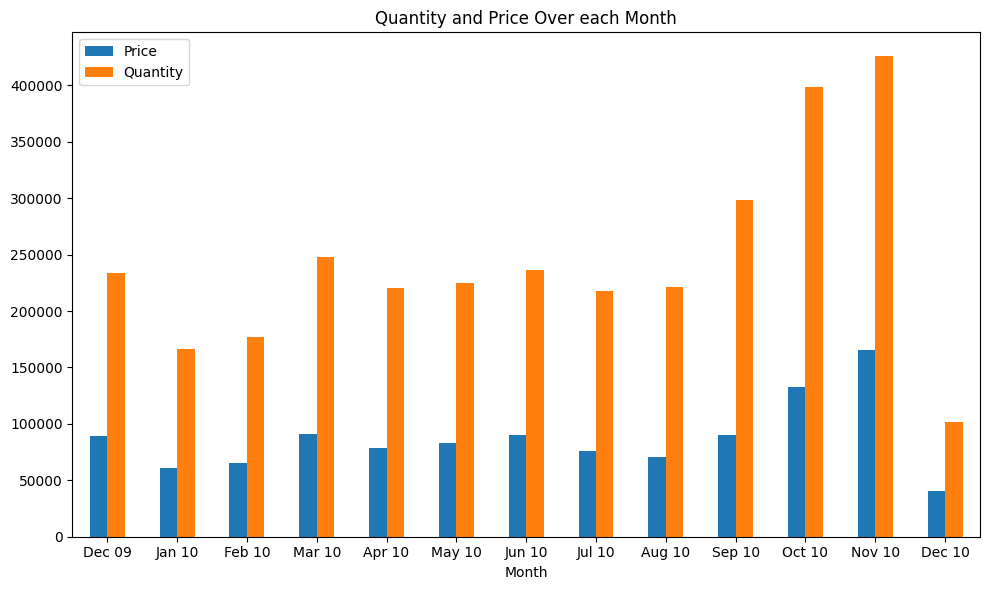

In [74]:
year_month = year_month = df["InvoiceDate"].dt.strftime('%Y_%m')

data_plot = df.groupby(year_month)[["Price", "Quantity"]].sum()

# Plotting the top 10 customers
fig, ax = plt.subplots(figsize=(10, 6))
data_plot.plot(kind='bar', ax=ax)

ax.set_xlabel("Month")
ax.set_ylabel("")
ax.set_title("Quantity and Price Over each Month")

ax.set_xticklabels(('Dec 09', 'Jan 10', 'Feb 10', 'Mar 10', \
                    'Apr 10', 'May 10', 'Jun 10', 'Jul 10', \
                    'Aug 10', 'Sep 10', 'Oct 10', 'Nov 10', \
                    'Dec 10'), rotation = 'horizontal')

plt.tight_layout()

plt.savefig("figs/Which months were the most popular for this store.png", format="png")
plt.show()

- ***Which days of the month with the highest Profit and Quantity?***
    - seems that firs and last days of the week have the highest profit and quantity.

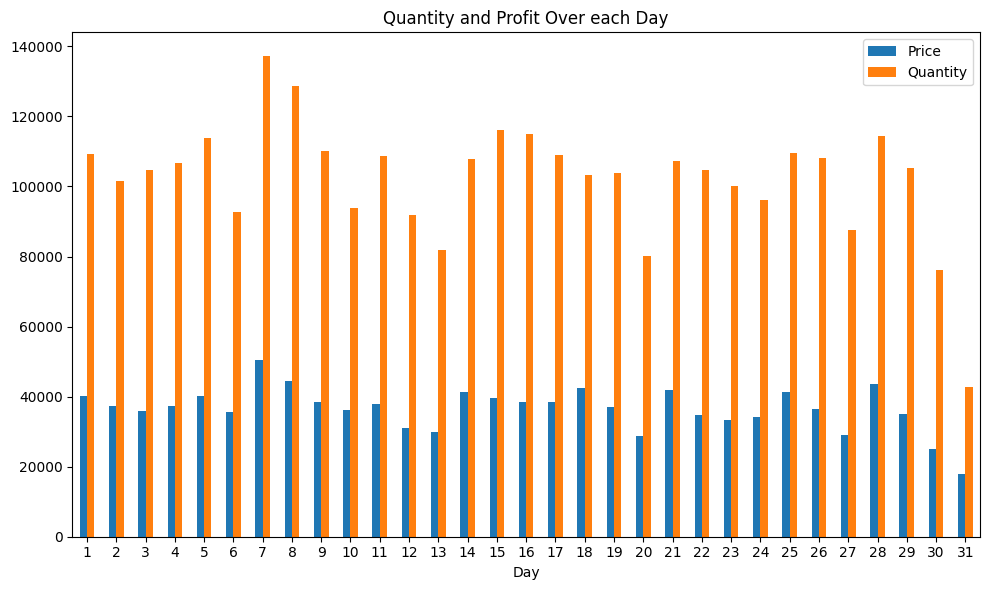

In [75]:
data_plot = df.groupby('Day')[["Price", "Quantity"]].sum()

# Plotting the top 10 customers
fig, ax = plt.subplots(figsize=(10, 6))
data_plot.plot(kind='bar', ax=ax)

ax.set_xlabel("Day")
ax.set_ylabel("")
ax.set_title("Quantity and Profit Over each Day")
plt.xticks(rotation=0)
plt.tight_layout()

plt.savefig("figs/Which days of the month were the most popular for this store.png", format="png")
plt.show()

- ***Which day of the week has the most and least amount of quantity and profit?***
    - Saturday has the least amount of quantity and Profit.
    - Thursday is the highest day with quantity and profit.

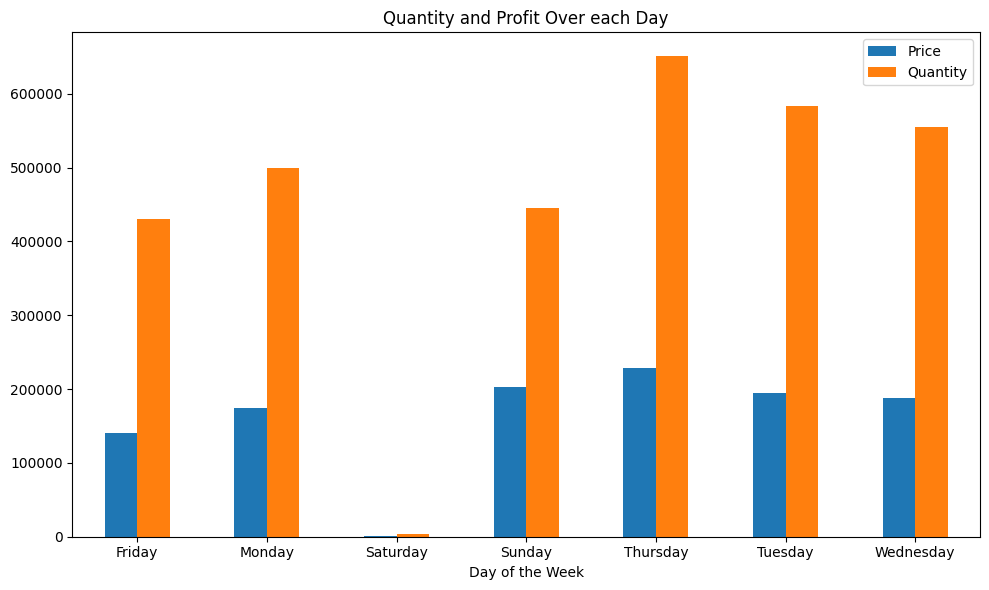

In [76]:
days = df['InvoiceDate'].dt.day_name()

data_plot = df.groupby(days)[["Price", "Quantity"]].sum()

# Plotting the top 10 customers
fig, ax = plt.subplots(figsize=(10, 6))
data_plot.plot(kind='bar', ax=ax)

ax.set_xlabel("Day of the Week")
ax.set_ylabel("")
ax.set_title("Quantity and Profit Over each Day")
plt.xticks(rotation=0)
plt.tight_layout()

plt.savefig("figs/Which days of the week were the most popular for this store.png", format="png")
plt.show()

- ***Which hour of the day has the highest quantity and profit?***
    - There is a clear trend in this graph: the number of orders increases from 7am onwards and peaks at noon, and then slowly decreases and ends at 8pm.
    - Most people order between 11am and 2pm. 

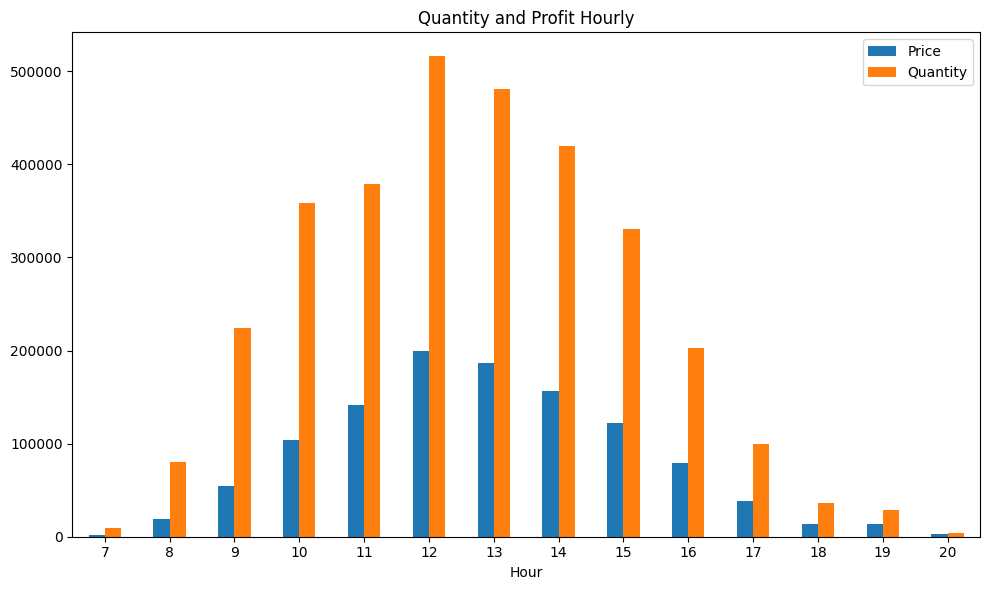

In [77]:
data_plot = df.groupby('Hour')[["Price", "Quantity"]].sum()

# Plotting the top 10 customers
fig, ax = plt.subplots(figsize=(10, 6))
data_plot.plot(kind='bar', ax=ax)

ax.set_xlabel("Hour")
ax.set_ylabel("")
ax.set_title("Quantity and Profit Hourly")
plt.xticks(rotation=0)
plt.tight_layout()

plt.savefig("figs/Which hours of the day were the most popular for this store.png", format="png")
plt.show()